In [1]:
import time
from numpy import *
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.ndimage.filters import gaussian_filter1d
import matplotlib.colors as colors
import Params
import LabFuncs
from PlotFuncs import *

SNdir = '../neutrinos/supernovae/'

In [2]:
def SNNeutrinoEnergyDist(E_nu,t,Eav,Eav2):
    alph = (2*Eav**2.0-Eav2)/(Eav2-Eav**2.0)
    phi = ((E_nu/Eav)**alph)*exp(-(alph+1)*E_nu/Eav)
    phi /= trapz(phi,E_nu)
    return phi

def SNFlux(E_nu,dat,distance=10.0):
    kpc = 100*1000.0*3.086e16 # centimetres
    foe = 1e44/(1.6e-19*1e6) # MeV
    unit_conversion = foe/kpc**2.0
    t = dat[:,0]
    L = dat[:,1]
    Eav = dat[:,2]
    Eav2 = dat[:,3]
    flux = zeros(shape=(size(t),size(E_nu)))
    mask = arange(0,size(t))[L>0.0]
    for i in mask:
        phi = SNNeutrinoEnergyDist(E_nu,t[i],Eav[i],Eav2[i])
        flux[i,:] = unit_conversion*(L[i]/(4*pi*distance**2.0))*phi/Eav[i]
    flux_int = trapz(flux.T,t)
    return flux,flux_int


n_Enu = 1000
E_nu_SN = logspace(-3.0,2.5,n_Enu) # MeV
distance = 5.0 # kpc

# M = 11.2
Mdir = 'LS220-s11.2c/'
dat11 = loadtxt(SNdir+Mdir+'nu_e.txt')
dat12 = loadtxt(SNdir+Mdir+'nubar_e.txt')
dat13 = loadtxt(SNdir+Mdir+'nu_x.txt')
flux11,_ = SNFlux(E_nu_SN,dat11)
flux12,_ = SNFlux(E_nu_SN,dat12)
flux13,_ = SNFlux(E_nu_SN,dat13)

# M = 27
Mdir = 'LS220-s27.0co/'
dat21 = loadtxt(SNdir+Mdir+'nu_e.txt')
dat22 = loadtxt(SNdir+Mdir+'nubar_e.txt')
dat23 = loadtxt(SNdir+Mdir+'nu_x.txt')
dat24 = loadtxt(SNdir+Mdir+'nubar_x.txt')
flux21,_ = SNFlux(E_nu_SN,dat21)
flux22,_ = SNFlux(E_nu_SN,dat22)
flux23,_ = SNFlux(E_nu_SN,dat23)
flux24,_ = SNFlux(E_nu_SN,dat24)


In [3]:
maxi = 1000
tmin = -0.1
tmax = 8.0
timesSN = linspace(tmin,tmax,maxi)
Ftot1 = zeros(shape=(maxi,n_Enu))
Ftot2 = zeros(shape=(maxi,n_Enu))
for i in range(0,n_Enu):
    Ftot1[:,i] = interp(timesSN,dat11[:,0],flux11[:,i],left=0.0,right=0.0)\
                + interp(timesSN,dat12[:,0],flux12[:,i],left=0.0,right=0.0)\
                + interp(timesSN,dat13[:,0],flux13[:,i],left=0.0,right=0.0)
    Ftot2[:,i] = interp(timesSN,dat21[:,0],flux21[:,i],left=0.0,right=0.0)\
                + interp(timesSN,dat22[:,0],flux22[:,i],left=0.0,right=0.0)\
                + interp(timesSN,dat23[:,0],flux23[:,i],left=0.0,right=0.0)\
                + interp(timesSN,dat24[:,0],flux24[:,i],left=0.0,right=0.0)

In [4]:
from LabFuncs import *
from Params import *

Nuc = F19
Loc = Boulby

def dRdEdO_SN(E,q_SN,E_nu,Flux,Nuc,Loc): # Directional CEnuNS for Solar
    N = Nuc.NumberOfNeutrons
    Z = Nuc.NumberOfProtons
    Q_W = N-(1-4.0*sinTheta_Wsq)*Z # weak nuclear hypercharge
    m_N_GeV = 0.93141941*(N+Z) # nucleus mass in GeV
    m_N_keV = m_N_GeV*1.0e6 # nucleus mass in keV
    E_nu_keV = E_nu*1e3

    E_r = sqrt(E[:,0]**2 + E[:,1]**2 + E[:,2]**2) # Recoil energy
    x = zeros(shape=shape(E))
    x_sun = zeros(shape=shape(E))
    x[:,0] = E[:,0]/E_r # Recoil direction
    x[:,1] = E[:,1]/E_r
    x[:,2] = E[:,2]/E_r
    ne =size(E_r)
    dRdEdO = zeros(shape=ne)
    for i in range(0,ne):
        x_sun[i,:] = q_SN
    cos_th_sun = -(x_sun[:,0]*x[:,0]+x_sun[:,1]*x[:,1]+x_sun[:,2]*x[:,2])
    FF = LabFuncs.FormFactorHelm(E_r,N+Z)**2.0

    # CHROMATIC NEUTRINOS
    if Flux[1]>0.0:
        E_max = 2*m_N_keV*E_nu_keV[-1]**2.0/(m_N_keV+E_nu_keV[-1])**2
        i_range = range(0,ne)*(E_r<=E_max)
        i_sel = i_range[i_range!=0]
        for i in i_sel:
            costh = cos_th_sun[i]
            E_nu_min = sqrt(m_N_keV*E_r[i]/2.0)
            if costh>(E_nu_min/m_N_keV):
                Eps = 1.0/(costh/E_nu_min - 1.0/m_N_keV)
                diff_sigma = (G_F_GeV**2/(4*pi))*Q_W**2*m_N_GeV*\
                            (1-(m_N_keV*E_r[i])/(2*Eps**2))*(0.197e-13)**2.0\
                            *1e-6*1000/(N+1.0*Z)*(N_A)
                Eps = Eps*(Eps>E_nu_min)
                Eps = Eps*(Eps<E_nu_keV[-1])
                F_value = interp(Eps,E_nu_keV,Flux)
                dRdEdO[i] = diff_sigma*F_value*Eps**2.0/(1000*E_nu_min)*FF[i] # /kg/keV
    dRdEdO = dRdEdO*3600*24*365*1000/(2*pi) # /ton/year
    return dRdEdO

In [5]:
from WIMPFuncs import *
from NeutrinoFuncs import *

NuBG = GetNuFluxes(0.0,Nuc)
E_nu_all = NuBG.Energy
Flux_all = NuBG.Flux
n_nu = NuBG.NumberOfNeutrinos 
Errs = NuBG.Uncertainties

def Get_q_lab(q,JD):
    lat = Loc.Latitude
    lon = Loc.Longitude
    UT = 24*(JD+0.5-floor(JD+0.5))
    MJD = JD - 2400000.5
    T_0 = (floor(MJD)-55197.5)/36525.0
    t_GAST = (101.0308 + 36000.770*T_0 + 15.04107*UT)/15.0
    t_lab = t_GAST + lon/15.0
    t_lab = 15*t_lab # DEGREES
    q_lab = zeros(shape=shape(q))
    for i in range(0,shape(q)[0]):
        q_lab[i,:] =  gal2lab(q[i,:],t_lab, lat)
    return q_lab

def convertmap(R3D):
    R_map = zeros(shape=(int(n/2),n))
    ii = 0
    for i in range(0,int(n/2)):
        for j in range(0,n):
            R_map[i,j] = R3D[0,ii]
            ii = ii+1
    R_map = flipud(R_map)
    return R_map


def GetVectors(n):
    nn = int(n*n/2)
    PH, TH = meshgrid(linspace(0, 2*pi, n), linspace(-pi/2, pi/2, int(n/2)))
    X = cos(PH)*cos(TH)
    Y = -sin(PH)*cos(TH)
    Z = sin(TH)
    ii = 0
    q = zeros(shape=(nn,3))
    for i in range(0,int(n/2)):
        for j in range(0,n):
            q[ii,:] = array([X[i,j],Y[i,j],Z[i,j]])
            ii = ii+1
    return q,PH,TH

def GetMaps(E_th,E_max,t,ne,n,Loc=Boulby,Nuc=F19,HaloModel=SHM,DM=WIMP(10.0,1.0e-45)):
    E_r_vals = linspace(E_th,E_max,ne)
    nn = int(n*n/2)
    q,PH,TH = GetVectors(n)
    
    dR_wimp = zeros(shape=(1,int(n*n/2)))
    dR_nu = zeros(shape=(1,int(n*n/2)))
    q_lab = Get_q_lab(q,t)
    for i in range(0,ne):
        E = -1*E_r_vals[i]*q_lab
        dR_wimp = dR_wimp + dRdEdO_wimp(E,t*ones(shape=int(n*n/2)),DM,HaloModel,Nuc,Loc)  
        dR_nu = dR_nu + dRdEdO_solarnu(E,t*ones(shape=int(n*n/2)),E_nu_all[:,5],Flux_all[:,5],Nuc,Loc)
    dR_wimp = dR_wimp/amax(dR_wimp)
    dR_nu = dR_nu/amax(dR_nu)
    dR_mapw = zeros(shape=(int(n/2),n))
    dR_mapn = zeros(shape=(int(n/2),n))
    ii = 0
    for i in range(0,int(n/2)):
        for j in range(0,n):
            dR_mapw[i,j] = dR_wimp[0,ii]
            dR_mapn[i,j] = dR_nu[0,ii]
            ii = ii+1
    return q,PH,TH,dR_mapw,dR_mapn


def GetSNMap(E_nu_SN,Ftot,E_th,E_max,q_SN,it_SN,ne,n,Loc=Boulby,Nuc=F19,distance=10.0):
    Flux_SN = Ftot[it_SN,:]*(10.0/distance)**2.0
    E_r_vals = linspace(E_th,E_max,ne)
    nn = int(n*n/2)
    dR_SN = zeros(shape=(1,int(n*n/2)))
    for i in range(0,ne):
        E = -1*E_r_vals[i]*q
        dR_SN = dR_SN + dRdEdO_SN(E,q_SN,E_nu_SN,Flux_SN,Nuc,Loc)
    dR_SN = dR_SN/amax(dR_SN)
    dR_mapsn = zeros(shape=(int(n/2),n))
    ii = 0
    for i in range(0,int(n/2)):
        for j in range(0,n):
            dR_mapsn[i,j] = dR_SN[0,ii]
            ii = ii+1
    return q,PH,TH,dR_mapsn

In [6]:
import cartopy.crs as ccrs
import matplotlib.gridspec as gridspec
import matplotlib.ticker as mticker
import matplotlib.colors as colors
from astropy import units as u
from astropy.coordinates import SkyCoord, get_constellation

plt.rcParams['axes.linewidth'] = 3
plt.rc('text', usetex=True)
plt.rc('font', family='serif',size=15)


cygnus_stars = array(['β','η','γ','α','γ','δ','ι','κ','ι','δ','γ','ε','ζ'])
#cygnus_stars = ['Deneb','gamma cyg']
nst = size(cygnus_stars)
cyg = zeros(shape=(nst,2))
for i in range(0,nst):
    c = SkyCoord.from_name(cygnus_stars[i]+' Cyg').galactic
    cyg[i,:] = array([c.l.degree,c.b.degree])
    
def Psun(JD):
    lat = Loc.Latitude
    lon = Loc.Longitude
    UT = 24*(JD+0.5-floor(JD+0.5))
    MJD = JD - 2400000.5
    T_0 = (floor(MJD)-55197.5)/36525.0
    t_GAST = (101.0308 + 36000.770*T_0 + 15.04107*UT)/15.0
    t_lab = t_GAST + lon/15.0
    t_lab = 15*t_lab # DEGREES
    q_sun = lab2gal(SolarDirection(JD,Loc),t_lab,lat)
    return array([arctan2(-q_sun[1],q_sun[0]),arcsin(q_sun[2])])*180/pi


# ecliptic
ntt = 200
times = Jan1+linspace(0,364,ntt)
ecl = zeros(shape=(ntt,2))
for i in range(0,ntt):
    JD = times[i]
    ecl[i,:] = Psun(times[i])
ecl = ecl[argsort(ecl[:,0]),:]

Months = array(['January','February','March','April','May','June','July','August','September','October','November','December'])
datecumsum = cumsum(array([31,28,31,30,31,30,31,31,30,31,30,31]))

c = SkyCoord.from_name('Betelgeuse').galactic
l = c.l.degree
b = c.b.degree
q_SN = array([cos(b*pi/180.0)*cos(l*pi/180.0),cos(b*pi/180.0)*sin(l*pi/180.0),sin(b*pi/180.0)])
Betelgeuse = array([l,b])

In [7]:
E_th = 3.0
E_max = 50.0

E_r = linspace(E_th,E_max,100)
dR1 = zeros(shape=maxi)
dR2 = zeros(shape=maxi)
for i in range(0,maxi):
    dR1[i] = trapz(dRdE_nu(E_r,0.0,False,E_nu_SN,Ftot1[i,:],F19),E_r)
    dR2[i] = trapz(dRdE_nu(E_r,0.0,False,E_nu_SN,Ftot2[i,:],F19),E_r)

1 0 -3.0 0
1 1 -2.949748743718593 0
1 2 -2.899497487437186 0
1 3 -2.849246231155779 0
1 4 -2.798994974874372 0
1 5 -2.748743718592965 0
1 6 -2.698492462311558 0
1 7 -2.648241206030151 0
1 8 -2.5979899497487438 0
1 9 -2.5477386934673367 0
1 10 -2.4974874371859297 0
1 11 -2.4472361809045227 0
1 12 -2.3969849246231156 0
1 13 -2.3467336683417086 0
1 14 -2.2964824120603016 0
1 15 -2.2462311557788945 0
1 16 -2.1959798994974875 0
1 17 -2.1457286432160805 0
1 18 -2.0954773869346734 0
1 19 -2.0452261306532664 0
1 20 -1.9949748743718592 0
1 21 -1.9447236180904521 0
1 22 -1.894472361809045 0
1 23 -1.844221105527638 0
1 24 -1.793969849246231 0
1 25 -1.743718592964824 0
1 26 -1.693467336683417 0
1 27 -1.64321608040201 0
1 28 -1.592964824120603 0
1 29 -1.5427135678391959 0
1 30 -1.4924623115577889 0
1 31 -1.4422110552763818 0
1 32 -1.3919597989949748 0
1 33 -1.3417085427135678 0
1 34 -1.2914572864321607 0
1 35 -1.2412060301507537 0
1 36 -1.1909547738693467 0
1 37 -1.1407035175879396 0
1 38 -1.090452

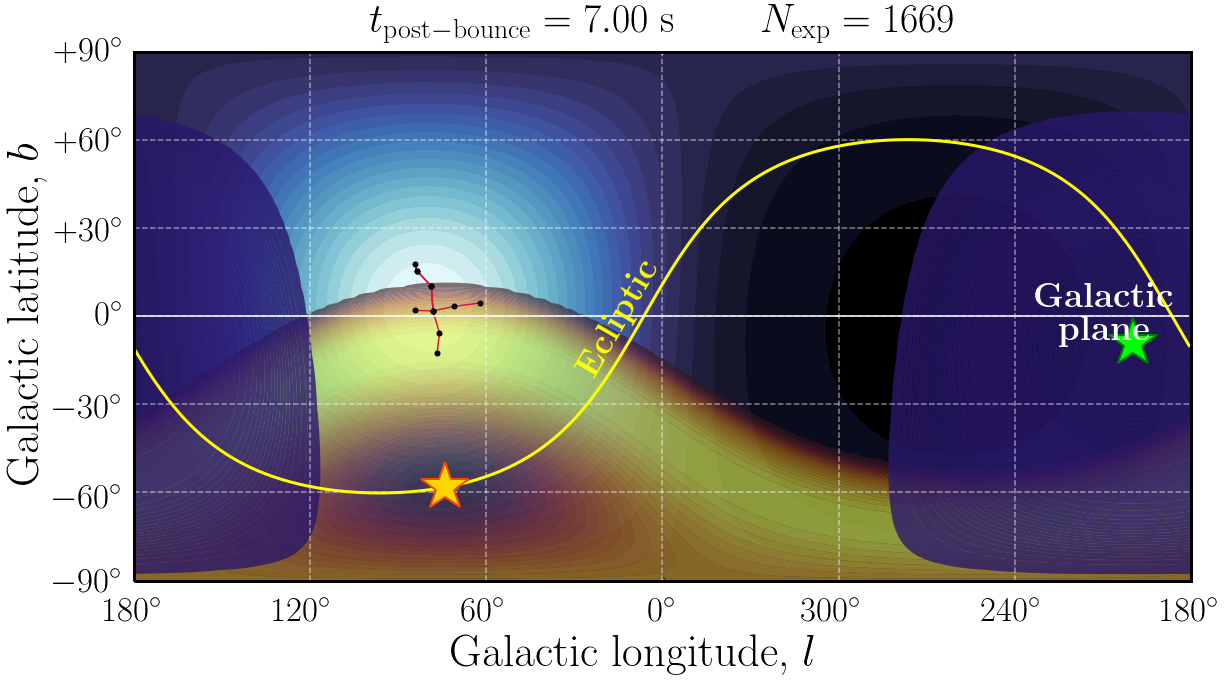

2 0 -3.0 0
2 1 -2.949748743718593 0
2 2 -2.899497487437186 0
2 3 -2.849246231155779 0
2 4 -2.798994974874372 0
2 5 -2.748743718592965 0
2 6 -2.698492462311558 0
2 7 -2.648241206030151 0
2 8 -2.5979899497487438 0
2 9 -2.5477386934673367 0
2 10 -2.4974874371859297 0
2 11 -2.4472361809045227 0
2 12 -2.3969849246231156 0
2 13 -2.3467336683417086 0
2 14 -2.2964824120603016 0
2 15 -2.2462311557788945 0
2 16 -2.1959798994974875 0
2 17 -2.1457286432160805 0
2 18 -2.0954773869346734 0
2 19 -2.0452261306532664 0
2 20 -1.9949748743718592 0
2 21 -1.9447236180904521 0
2 22 -1.894472361809045 0
2 23 -1.844221105527638 0
2 24 -1.793969849246231 0
2 25 -1.743718592964824 0
2 26 -1.693467336683417 0
2 27 -1.64321608040201 0
2 28 -1.592964824120603 0
2 29 -1.5427135678391959 0
2 30 -1.4924623115577889 0
2 31 -1.4422110552763818 0
2 32 -1.3919597989949748 0
2 33 -1.3417085427135678 0
2 34 -1.2914572864321607 0
2 35 -1.2412060301507537 0
2 36 -1.1909547738693467 0
2 37 -1.1407035175879396 0
2 38 -1.090452

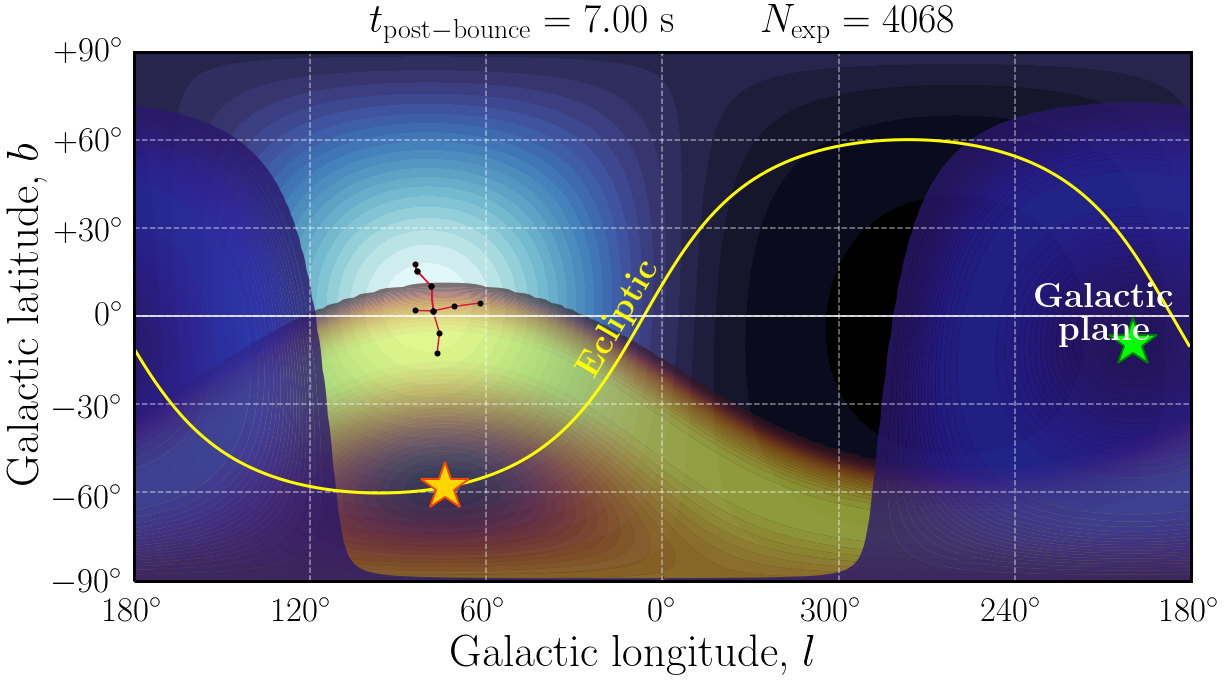

In [102]:
import cmocean
from mpl_toolkits.axes_grid1 import make_axes_locatable

t0 = 67
ne = 20
n = 200
q,PH,TH,dR_mapw,dR_mapn = GetMaps(E_th,E_max,t0+Jan1,ne,n)
    
    
cmax = 1.0
cmin = 0.0

cmap = cmocean.cm.deep_r
nlevels = 20
tfs = 35
gridlinecolor = 'w'


# PlateCarree

xtx = array([-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01])
ytx = array([0.0,0.16,0.33,0.5,0.66,0.83,1.0])
tx = array([r'$-90^\circ$',r'$-60^\circ$',r'$-30^\circ$',r'$0^\circ$',r'$+30^\circ$',r'$+60^\circ$',r'$+90^\circ$']) 
xtx_l = array([0.0,0.16,0.33,0.5,0.66,0.83,1.0])
ytx_l = array([-0.03,-0.03,-0.03,-0.03,-0.03,-0.03,-0.03])
tx_l = array([r'$180^\circ$',r'$120^\circ$',r'$60^\circ$',r'$0^\circ$',r'$300^\circ$',r'$240^\circ$',r'$180^\circ$']) 

# Betelgeuse
d_BG = 197*1.0e-3 # kpc
dRS = (10.0/d_BG)**2.0
Ntot = 0.0

maxR = max(amax(dR1),amax(dR2))
Rescale = dRS/(365*24*3600.0)

tstart = -3.0
tend = 7.0
framerate = 20.0

nt = int((tend-tstart)*framerate)
trange = linspace(tstart,tend,nt)

# Which mass
for choice in [1,2]:

    # Set up figure
    fig, axarr = plt.subplots(1, 1,figsize=(20,10))
    gs = gridspec.GridSpec(1, 1)
    gs.update(wspace=0.1)
    ax = plt.subplot(gs[0],projection=ccrs.PlateCarree())
    for i in range(0,nt):
        ti = trange[i]
        iSN = argmin(abs(ti-timesSN))
        print(choice,i,ti,iSN)
        if (iSN>=1) and (iSN<(maxi-1)):
            tSN = timesSN[iSN]
            if choice==1:
                q,PH,TH,dR_mapsn = GetSNMap(E_nu_SN,Ftot1,E_th,E_max,q_SN,iSN,ne,n,distance=d_BG)
                Ntot = around(trapz(dR1[0:iSN]*Rescale,timesSN[0:iSN]))
                FluxScale = dR1[iSN]/maxR
            elif choice==2:
                q,PH,TH,dR_mapsn = GetSNMap(E_nu_SN,Ftot2,E_th,E_max,q_SN,iSN,ne,n,distance=d_BG)
                Ntot = around(trapz(dR2[0:iSN]*Rescale,timesSN[0:iSN]))
                FluxScale = dR2[iSN]/maxR

        #dR_mapsn[dR_mapsn==0] = nan
        con1 = ax.imshow(dR_mapsn,cmap=cmocean.cm.haline,vmin=0.0,vmax=0.1)

        ax.clear()
        # Axis lines
        gl = ax.gridlines(color=gridlinecolor,linewidth=1.5, linestyle='--',alpha=0.5)
        gl.ylocator = mticker.FixedLocator([-90,-60, -30, 0, 30, 60,90])
        ax.outline_patch.set_linewidth(3)


        cbar = plt.colorbar(con1, pad=0.03,extend='max',use_gridspec=True,fraction=0.023)
        cbar.ax.tick_params(labelsize=25)
        cbar.set_label(label=r'Rate/max(Rate)',fontsize=40,rotation=-90,labelpad=40)


        for j in range(0,size(xtx)):
            plt.text(xtx[j],ytx[j],tx[j],transform=ax.transAxes,horizontalalignment='right',verticalalignment='center',fontsize=tfs)
            plt.text(xtx_l[j],ytx_l[j],tx_l[j],transform=ax.transAxes,horizontalalignment='center',verticalalignment='top',fontsize=tfs)

        ax.plot(-cyg[0:4,0],cyg[0:4,1],'-',color='crimson',transform=ccrs.PlateCarree())
        ax.plot(-cyg[4:,0],cyg[4:,1],'-',color='crimson',transform=ccrs.PlateCarree())
        points = ax.plot(-cyg[:,0],cyg[:,1],'.',color='k',ms=10,transform=ccrs.PlateCarree())
        ax.text(127,3,r'{\bf Galactic}',color=gridlinecolor,transform=ccrs.PlateCarree(),fontsize=tfs)
        ax.text(135,-8,r'{\bf plane}',color=gridlinecolor,transform=ccrs.PlateCarree(),fontsize=tfs)
        ax.plot(ecl[:,0],ecl[:,1],'-',lw=3,color='yellow',transform=ccrs.PlateCarree())
        ax.text(-30,-20,r'{\bf Ecliptic}',color='yellow',transform=ccrs.PlateCarree(),fontsize=tfs,rotation=60)
        ax.background_patch.set_facecolor('k')
        ax.plot(Psun(t0+Jan1)[0],Psun(t0+Jan1)[1],'y*',ms=50,markerfacecolor='gold',mec='orangered',mew=2,transform=ccrs.PlateCarree())

        ax.plot(-Betelgeuse[0],Betelgeuse[1],'g*',ms=50,markerfacecolor='lime',mec='green',mew=2,transform=ccrs.PlateCarree())

        ax.contourf(rad2deg(PH), rad2deg(TH), dR_mapw,levels=linspace(0.01,1.0,25),transform=ccrs.PlateCarree(),cmap=cmocean.cm.ice,vmin=0.0,vmax=1.0)
        ax.contourf(rad2deg(PH), rad2deg(TH), dR_mapn,levels=linspace(0.01,1.0,25),transform=ccrs.PlateCarree(),cmap=cmocean.cm.solar,vmin=0.0,vmax=1.0,alpha=0.6,antialiased=True)
        if sum(dR_mapsn)>0.0:
            dR_mapsn *= FluxScale
            cminSN = 0.01*FluxScale
            cmaxSN = amax(dR_mapsn)
            dR_mapsn[dR_mapsn==0] = nan
            ax.contourf(rad2deg(PH), rad2deg(TH), dR_mapsn,levels=linspace(cminSN,cmaxSN,20),transform=ccrs.PlateCarree(),cmap=cmocean.cm.haline,vmin=0.0,vmax=0.1,alpha=0.8,antialiased=True)
        ax.text(0.3,-0.16,'Galactic longitude, $l$',transform=ax.transAxes,fontsize=tfs+10)
        ax.text(-0.12,0.2,'Galactic latitude, $b$',transform=ax.transAxes,fontsize=tfs+10,rotation=90)
        ax.set_title(r'$t_{\rm post-bounce} = '+'{:.2f}'.format(ti)+r'$ s \quad\quad'\
                     +r'$N_{\rm exp} = $ '+str(int(Ntot)),fontsize=tfs+5,pad=15)
        line = ax.plot([-181,181],[0,0],'-',color=gridlinecolor,lw=1.5,transform=ccrs.PlateCarree())
        ax.plot([0,0],[-90,90],'.',color=gridlinecolor,transform=ccrs.PlateCarree())
        fig.savefig('../movies/Skymaps_SN/'+str(choice)+'_'+str(i)+'.png',bbox_inches='tight')

        cbar.remove()
    plt.show()




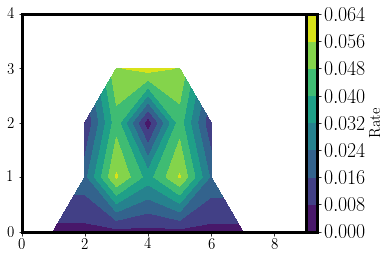

In [52]:
con1 = plt.contourf(dR_mapsn)
cbar = plt.colorbar(con1, pad=0.0,label='Rate',extend='max')
cbar.ax.tick_params(labelsize=20)
plt.show()


In [9]:
dR_mapsn

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])

array([[0.12109666, 0.12109666, 0.12109666, 0.12109666, 0.12109666,
        0.12109666, 0.12109666, 0.12109666, 0.12109666, 0.12109666,
        0.12109666, 0.12109666, 0.12109666, 0.12109666, 0.12109666,
        0.12109666, 0.12109666, 0.12109666, 0.12109666, 0.12109666,
        0.1449429 , 0.10417382, 0.07421908, 0.05482369, 0.04381727,
        0.03939114, 0.04064076, 0.04783214, 0.06233402, 0.08618548,
        0.1211739 , 0.16607768, 0.21571954, 0.26071886, 0.29057954,
        0.2975261 , 0.27971828, 0.24183147, 0.19349819, 0.1449429 ,
        0.17175867, 0.09268087, 0.04718305, 0.02485353, 0.01503375,
        0.0118342 , 0.01269545, 0.01837295, 0.03272267, 0.06397463,
        0.12355259, 0.21841744, 0.33908236, 0.45706474, 0.53772651,
        0.5566641 , 0.50821163, 0.40698861, 0.283469  , 0.17175867,
        0.19757631, 0.08680218, 0.0337208 , 0.01307514, 0.00608451,
        0.00403232, 0.00457028, 0.00831391, 0.01980598, 0.05193969,
        0.12803693, 0.26875834, 0.4615666 , 0.65